In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
from IPython.display import Image

# Required for importing scattering data
import h5py
import urllib.request
import tables

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

# Bayesian truncation errors in chiral effective field theory: A Pointwise Approach

Here we reproduce, using the improved truncation error model based on conjugate priors, some of the results in the following papers (with some notational changes)

* Furnstahl et al., [Quantifying Truncation Errors in Effective Field Theory](https://arxiv.org/abs/1506.01343)
* Melendez et al., [Bayesian truncation errors in chiral effective field theory: Nucleon-nucleon observables](https://arxiv.org/abs/1704.03308)

In these papers, the convergence pattern of nucleon-nucleon scattering observables, including the total and differential cross sections and a set of spin scattering observables, were studied to infer the effective field theory (EFT) truncation error. Given the $k$ lowest order EFTs, a sequence of observable calculations $\\{y_0, ..., y_k\\}$ can be computed for a generic observable $y$. It is assumed in the above papers that one can write the sum of all contributions as

\begin{align*}
y = y_{\mathrm{ref}}\sum_{n=0}^\infty c_n Q^n
\end{align*}

for iid observable coefficients $c_n$. Hence, the $k$ lowest orders can be conditioned upon to estimate the remaining higher orders, and the full summation.
The expansion parameter $Q$ is considered a ratio of low- and high-energy scales, with the low energy scale a combination of the relative scattering momentum $p$ and pion mass $m_\pi$, and the high energy scale is $\Lambda_b$, also known as the breakdown scale.
The specific parameterization is

\begin{align*}
Q = \frac{m_\pi^n + p^n}{m_\pi^{n-1} + p^{n-1}} \frac{1}{\Lambda_b}
\end{align*}

with $n=8$ used in Melendez et al.

The hierarchical model from the above papers considered the following prior sets, and Melendez et al. focused on set C with $\bar c_< = 0.25$ and $\bar c_> = 10$.




<!--- | Set | $pr(c_n | \bar c)$ | $pr(\bar c)$ |
| :---: | :------------------: | :------------: |
| A   | $\frac{1}{2\bar c}\theta(\bar c - |c_n|)$ |  $\frac{1}{\bar c\ln\bar c_> /\bar c_<}\theta(\bar c - \bar c_<) \theta(\bar c_> - \bar c)$ |
| B   | $\frac{1}{2\bar c}\theta(\bar c - |c_n|)$ | $\frac{1}{\sqrt{2\pi}\bar c \sigma} e^{-(\ln \bar c)^2/2\sigma^2}$ |
| C  | $\frac{1}{\sqrt{2\pi}\bar c} e^{-c_n^2/2\bar c}$ | $\frac{1}{\bar c\ln\bar c_> /\bar c_<}\theta(\bar c - \bar c_<) \theta(\bar c_> - \bar c)$ | --->



\begin{array}{ccc} \hline
\mathrm{Set} & pr(c_n | \bar c) & pr(\bar c) \\
\hline
A & \frac{1}{2\bar c}\theta(\bar c - |c_n|) &  \frac{1}{\bar c\ln\bar c_> /\bar c_<}\theta(\bar c - \bar c_<) \theta(\bar c_> - \bar c) \\
B & \frac{1}{2\bar c}\theta(\bar c - |c_n|) &  \frac{1}{\sqrt{2\pi}\bar c \sigma} e^{-(\ln \bar c)^2/2\sigma^2} \\
C & \frac{1}{\sqrt{2\pi}\bar c} e^{-c_n^2/2\bar c} &  \frac{1}{\bar c\ln\bar c_> /\bar c_<}\theta(\bar c - \bar c_<) \theta(\bar c_> - \bar c) \\
\hline
\end{array}

This package instead employs a conjugate prior set, where the $c_n$ are Gaussian and an inverse $\chi^2$ is placed on $\bar c^2$,

\begin{align*}
\bar c^2 \sim \chi^{-2}(\nu_0, \tau_0^2)
\end{align*}

where $\nu_0$ and $\tau_0$ are the prior degrees of freedom and scale parameters, respectively.
The inverse $\chi^2$ density is given by

\begin{align*}
\chi^{-2}(z; \nu, \tau^2) = \frac{(\nu\tau^2/2)^{\nu/2}}{\Gamma(\nu/2)} z^{-\nu/2-1} e^{-\frac{\nu\tau^2}{2z}}
\end{align*}

Here we compare the results of the very convenient conjugate formulation to the prior published results.


## Proof of Concept

Many proof of concept tests were performed in Furnstahl et al.
Here we reproduce some of those tests with this package.
Since setting $\nu = 0$ is equivalent to prior set $C$ with $\bar c_< = 1/\bar c_> = 0$, the results should be identical in this case.

The basic steps for using this uncorrelated model are

* Define a ``TruncationPointwise`` model object with hyperparameters $\nu$ and $\tau$
* Use the ``fit`` method to update hyperparameters based on the order-by-order predictions $y_n$, expansion parameter $Q$, and reference scale $y_{\mathrm{ref}}$.
* Then call other methods, such as ``interval`` to get posteriors or degree of belief intervals for the truncation error.

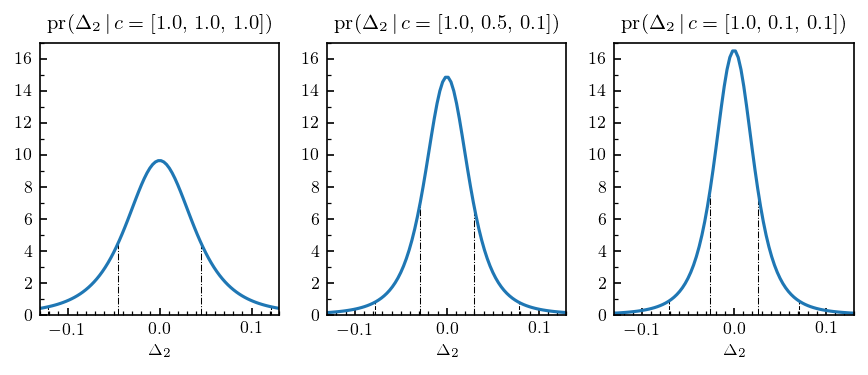

In [3]:
df0 = 0
Q = 0.33

# Must be 2d array, with orders spanning the last axis (columns)
coeffs = np.array(
    [[1.0, 1.0, 1.0],  # Set 1, orders 0, 1, 2
     [1.0, 0.5, 0.1],  # Set 2, orders 0, 1, 2
     [1.0, 0.1, 0.1]   # Set 3, orders 0, 1, 2
    ]
)

# The truncation model accepts *partial sums*,
# i.e., order-by-order predictions y_n, not the coefficients!
y1 = gm.partials(coeffs, ratio=Q)
y_best = y1[:, -1]

# Set up a scale-invariant truncation object
test1 = gm.TruncationPointwise(df=df0)

# Fit the model to data. Hyperparameters get updated here
test1.fit(y=y1, ratio=Q)

# Compute degree of belief (dob) intervals, aka credible intervals
dob68 = lower68, upper68 = test1.interval(0.68, orders=2)
pdf_heights68 = test1.pdf(lower68[:, None], orders=2)
dob95 = lower95, upper95 = test1.interval(0.95, orders=2)
pdf_heights95 = test1.pdf(lower95[:, None], orders=2)

# Plot the results
delta_k = np.linspace(-0.15, 0.15, 100)  # Differences from the true y
pdfs = test1.pdf(delta_k[:, None, None] + y1, orders=2)

fig, axs = plt.subplots(1, len(coeffs), figsize=(7, 2.4))
for i, ax in enumerate(axs.ravel()):
    ax.plot(delta_k, pdfs[:, i])

    # Plot dob intervals as vertical lines
    for dob in dob68-y_best:
        ax.vlines(dob[i], 0, pdf_heights68[i], linestyle='-.', lw=0.5)
    for dob in dob95-y_best:
        ax.vlines(dob[i], 0, pdf_heights95[i], linestyle='--', lw=0.5)

    # Format the plot as in Furnstahl et al. for comparison
    ax.set_title(r"$\mathrm{{pr}}(\Delta_2 \,\vert\, c=[{},\, {},\, {}])$".format(*coeffs[i]))
    ax.set_xlabel(r"$\Delta_2$")
    ax.set_ylim([0, 17])
    ax.set_xlim([-0.13, 0.13])
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(np.arange(0, 18, 2)))
    ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(1, 19, 2)))
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(np.linspace(-0.15, 0.15, 31)))

Compare the above figure with the blue curves from Fig. 4 in Furnstahl et al., reproduced below:

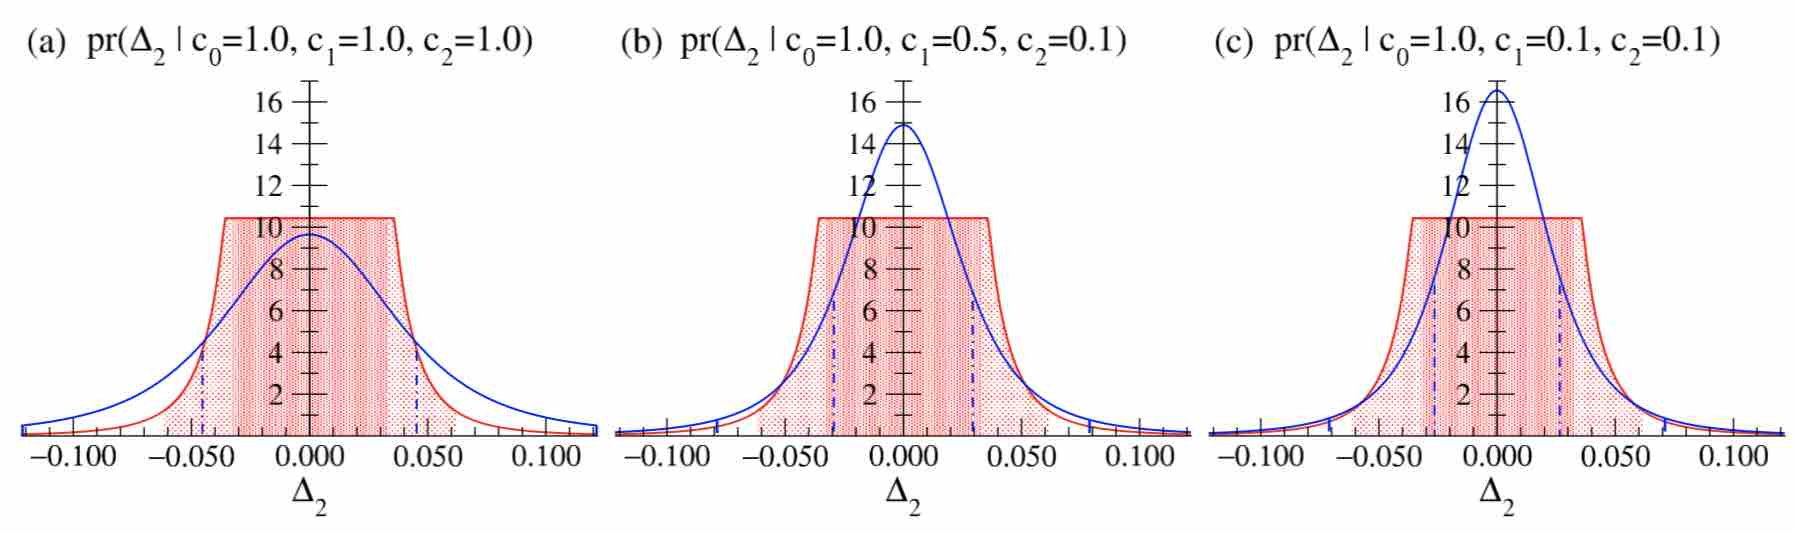

In [4]:
Image('../images/Furnstahl_fig4.jpg', width=WIDE_IMG_WIDTH)

The original paper states that Fig. 4 uses the "leading-omitted-term approximation" to the truncation error, but this is a misprint. Thus, the curves are indeed identical. This package allows any $\nu$ and $\tau^2$ to be chosen instead, each of which allow pdfs to be computed efficiently without any manual integration.

## NN Scattering Observables

Although the total cross section was covered in Furnstahl et al., it and other observables were more extensively studied in Melendez et al.
Here we will reproduce some of the key figures from Melendez et al. with a slightly altered prior on $\bar c$.

### Choose Hyperparameters

First let's figure out the hyperparameters of the inverse $\chi^2$ distribution that best reproduce the "Set C" prior with $\bar c_> = 10$ and $\bar c_< = 0.25$, which was the most extensively used prior set of Melendez et al.
Scipy has an inverse gamma distribution, which is equivalent to the inverse $\chi^2$ distribution, with hyperparameters defined by

\begin{align*}
    a & = \frac{\nu}{2} \\
    b & = \frac{\nu \tau^2}{2}
\end{align*}

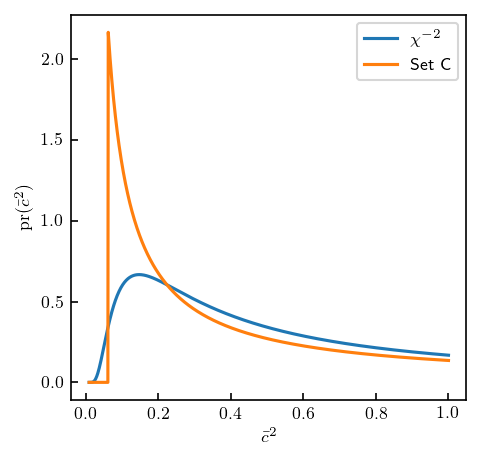

In [5]:
df_test = 0.6
tau_test = 0.8

a_test = df_test/2.
b_test = df_test * tau_test**2 / 2
ig = stats.invgamma(a=a_test, scale=b_test)


def cbar_sq_prior_melendez_etal(x, lower, upper):
    # pr(cbar**2) for set C
    return np.where((lower <= x) & (x <= upper), 1 / (np.log(upper / lower) * x), 0.)

cbarsq = np.linspace(0.1**2, 1, 1000)
prior_vals = cbar_sq_prior_melendez_etal(cbarsq, 0.25**2, 10**2)

fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.plot(cbarsq, ig.pdf(cbarsq), label=r'$\chi^{-2}$')
ax.plot(cbarsq, prior_vals, label='Set C')
ax.set_xlabel(r"$\bar c^2$")
ax.set_ylabel(r"$\mathrm{pr}(\bar c^2)$")
ax.legend();

It looks like $\nu \approx 0.6$ and $\tau \approx 0.8$ work nicely! Let's see if we can reproduce old results now.

### Setup

Observables are considered at many values of the kinematic parameters $E_{\mathrm{lab}}$ and $\theta$.
The expansion parameter is assumed to vary in energy so we must provide a callable function rather than a constant as before.
Thus we will first define some functions for computing the expansion parameter.

In [6]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction, single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q


def ratio(X, Lambda_b):
    '''Assume energies are in the first column of X'''
    return Q_approx(X[:, 0], Lambda_b, interaction='np').ravel()

Now import the relevant data for each observable from a precomputed hdf5 file (this requires the `h5py` package).
Here we use Epelbaum, Krebs, and Meißner's $R=0.9$ fm potential up to N4LO as the order-by-order predictions, and the pwa93 as experimental data.

In [7]:
nn_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-0p9fm.h5?raw=true'

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = h5file.get_node('/SGT').read()
DSG = h5file.get_node('/DSG').read()
AY = h5file.get_node('/PB').read()
A = h5file.get_node('/A').read()
D = h5file.get_node('/D').read()
AXX = h5file.get_node('/AXX').read()
AYY = h5file.get_node('/AYY').read()
q_cm = h5file.get_node('/q_cm').read()
t_lab = h5file.get_node('/t_lab').read()
degrees = h5file.get_node('/degrees').read()

q_cm *= hbarc

nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

In [8]:
SGT.shape

(5, 350)

The reference scale $y_{\mathrm{ref}}$ was chosen to be $y_0$ for the total and differential cross section, but it was argued that $y_{\mathrm{ref}} = 1$ was sufficient for the spin observables. Here we set up interpolators that could be used with any energy or $\theta$ value.

In [9]:
sgt_ref = SGT[0]
dsg_ref = DSG[-1]

In [10]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
# markers = ['o', '^', 'v', 's']
markers = None
dark_col = 0.9
medium_col = 0.5
light_col = 0.25
dark_colors = [cmap(dark_col) for cmap in cmaps]
medium_colors = [cmap(medium_col) for cmap in cmaps]
light_colors = [cmap(light_col) for cmap in cmaps]

### Total Cross Section

In Melendez et al., we produced plots of residuals with statistical error bands for various EFT regulators and also ran model checking tests.
The residual is defined as

\begin{align*}
    y_{\mathrm{res}} \equiv y_{\mathrm{th}} - y_{\mathrm{exp}}
\end{align*}

First let's define the values of energies to be used in the analysis and get the imported data


In [11]:
orders = np.array([0, 2, 3, 4, 5]) # Chiral EFT orders
nn_excluded = [0]  # Ignore these orders in prediction
Lambdab = 600
sgt_ratio = Q_approx(t_lab, Lambdab, interaction='np')
print(sgt_ratio.shape, sgt_ref.shape)

(350,) (350,)


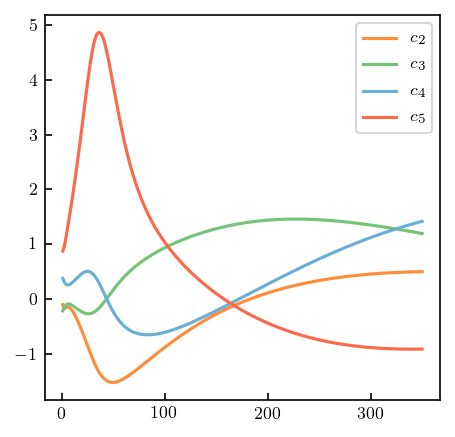

In [12]:
sgt_truncation = gm.TruncationPointwise(df=0, scale=0, excluded=nn_excluded)
sgt_truncation.fit(SGT.T, ratio=sgt_ratio, ref=sgt_ref, orders=orders)

fig, ax = plt.subplots(figsize=(3.4, 3.4))
for i, (n, coeff) in enumerate(zip(orders[1:], sgt_truncation.coeffs_.T)):
    ax.plot(t_lab, coeff, label=r'$c_{n}$'.format(n=n), c=medium_colors[i]);
ax.legend();

Let's start by reproducing the Fig. 7 from Melendez et al. We will again begin by fitting the model, and then calling  ``interval`` to find the the truncation error bands.

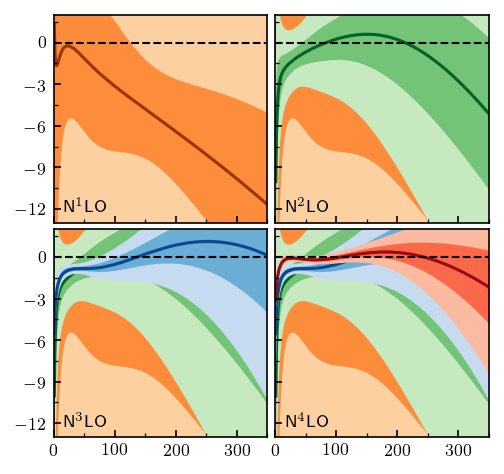

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.2), sharex=True, sharey=True)
for i, n in enumerate(orders[1:]):
    # Compute truncation errors for all orders less than y_i, skipping i=0
    sgt_truncation = gm.TruncationPointwise(df=df_test, scale=tau_test, excluded=nn_excluded)
    sgt_truncation.fit(SGT[:i+2].T, ratio=sgt_ratio, ref=sgt_ref, orders=orders[:i+2])
    sgt_intervals = sgt_lower, sgt_upper = sgt_truncation.interval([0.68, 0.95]) - SGT_nn_online[:, None]
    
    # Plot lines and bands
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(t_lab, SGT[i+1] - SGT_nn_online, color=dark_colors[i], zorder=i-5)
        ax.fill_between(t_lab, sgt_lower[1, ..., i], sgt_upper[1, ..., i], facecolor=light_colors[i], zorder=i-5)
        ax.fill_between(t_lab, sgt_lower[0, ..., i], sgt_upper[0, ..., i], facecolor=medium_colors[i], zorder=i-5)
    
    # Format
    ax = axes.ravel()[i]
    ax.axhline(0, 0, 1, ls='--', c='k', lw=1)
    ax.set_ylim(-13, 2)
    ax.set_xlim(0, 350)
    ax.set_yticks([-12, -9, -6, -3, 0])
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(np.linspace(50, 350, 4)))
    ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(-10.5, 2, 1.5)))
    ax.tick_params(which='both', direction='in')
    ax.text(0.05, 0.05, 'N$^{}$LO'.format(i+1), transform=ax.transAxes)
fig.tight_layout(h_pad=0.4, w_pad=0.2);

Compare the above figure with Fig. 7 from Melendez et al. 

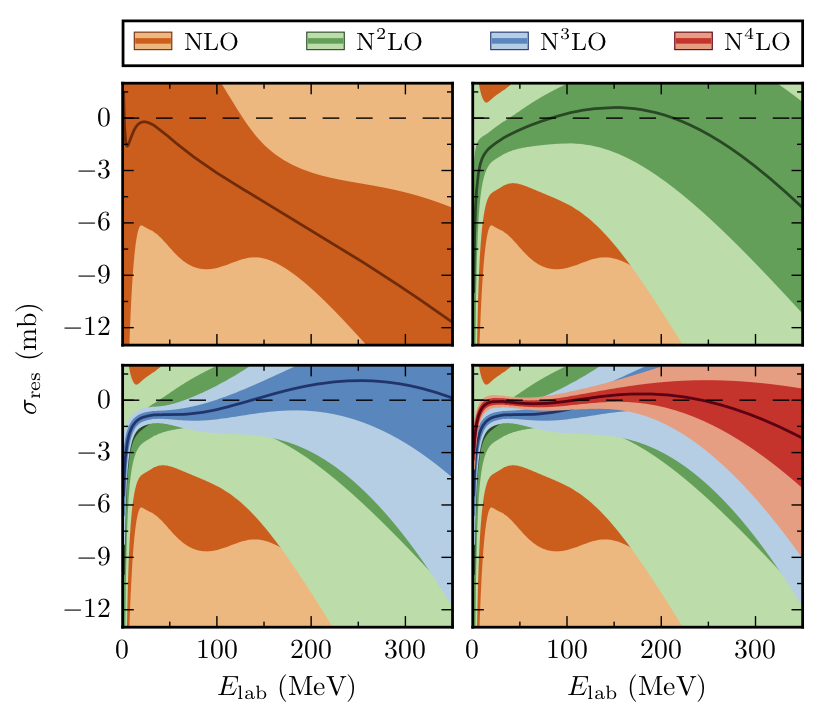

In [14]:
Image('../images/SGT_residuals_R0p9.png', width=NARROW_IMG_WIDTH, format='png')

### Differential Cross Section

Now set up differential cross section data

In [15]:
dsg_energy = 96

DSG_1d = np.squeeze(DSG[:, t_lab == dsg_energy])
dsg_ratio = Q_approx(dsg_energy, Lambdab, interaction='np')
dsg_ref = DSG_1d[-1]
DSG_nn_online_1d = np.squeeze(DSG_nn_online[t_lab == dsg_energy])
print(DSG_1d.shape, DSG_nn_online_1d.shape)

(5, 179) (179,)


Below we repeat the analysis for the differential cross section

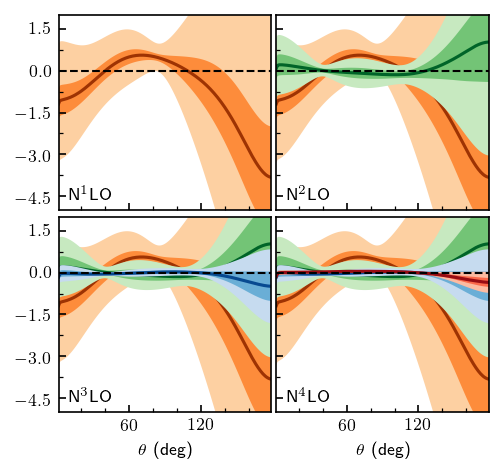

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.2), sharex=True, sharey=True)
for i, n in enumerate(orders[1:]):
    # Compute truncation errors for all orders less than y_i, skipping i=0
    dsg_truncation = gm.TruncationPointwise(df=df_test, scale=tau_test, excluded=nn_excluded)
    dsg_truncation.fit(DSG_1d[:i+2].T, ratio=dsg_ratio, ref=dsg_ref, orders=orders[:i+2])
    dsg_intervals = dsg_lower, dsg_upper = dsg_truncation.interval([0.68, 0.95]) - DSG_nn_online_1d[:, None]
    
    # Plot lines and bands
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(degrees, DSG_1d[i+1] - DSG_nn_online_1d, color=dark_colors[i], zorder=i-5)
        ax.fill_between(degrees, dsg_lower[1, ..., i], dsg_upper[1, ..., i], facecolor=light_colors[i], zorder=i-5)
        ax.fill_between(degrees, dsg_lower[0, ..., i], dsg_upper[0, ..., i], facecolor=medium_colors[i], zorder=i-5)
    
    # Format
    ax = axes.ravel()[i]
    ax.set_ylim([-5, 2])
    ax.set_xlim([1, 179])
    ax.set_yticks([-4.5, -3.0, -1.5, 0.0, 1.5])
    ax.set_xticks([60, 120])
    ax.axhline(0, ls='--', c='k', lw=1)
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(0, 180, 20)))
    ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(-3.75, 2, 1.5)))
    ax.text(0.05, 0.05, 'N$^{}$LO'.format(i+1), transform=ax.transAxes)
    ax.tick_params(which='both', direction='in')
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.4, w_pad=0.3);

Compare the above figure with Fig. 8 from Melendez et al.:

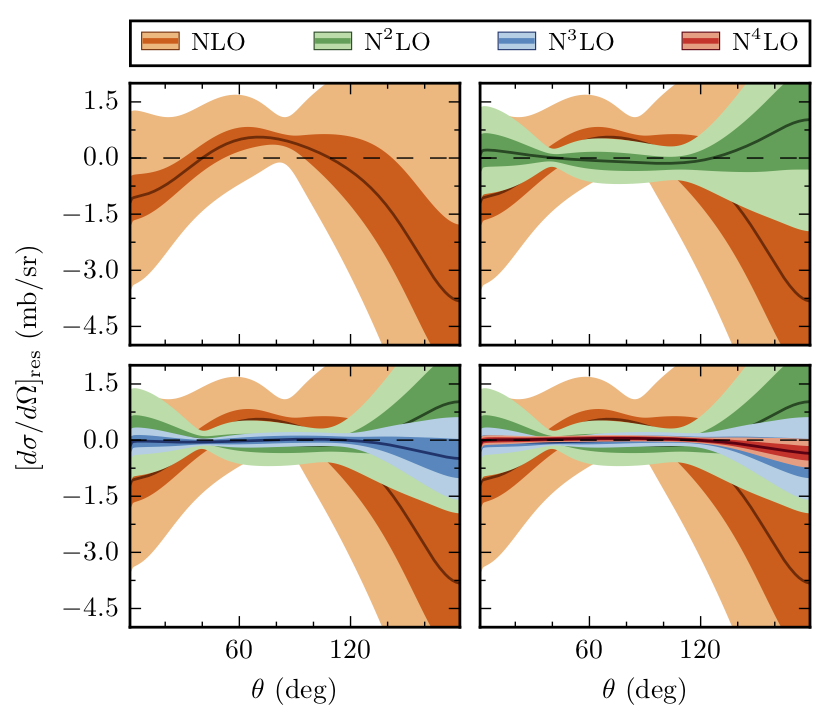

In [17]:
Image('../images/DSG_residuals_R0p9.png', format='png', width=NARROW_IMG_WIDTH)

### Model Checking

Two model checking diagnostics were employed in Melendez et al., consistency plots and $\Lambda_b$ posteriors.
Consistency plots check whether a $100\alpha\%$ degree of belief interval contains true value of the truncation error approximately $100\alpha\%$ of the time.
Validation data can be checked in this manner using the ``credible_diagnostic`` method, which computes the average number of points contained in a given credible interval.
The data should lie close to the diagonal in the plot below.
The 68% and 95% gray uncertainty bands allow for deviations from the diagonal due to the finite set of data.

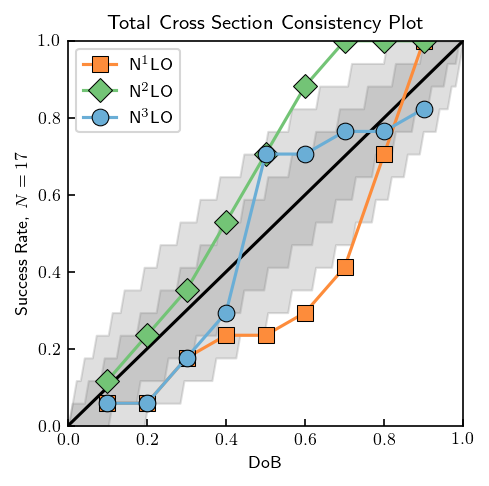

In [18]:
t_lab_consistency = np.arange(20, 341, 20)
ratio_consistency = Q_approx(t_lab_consistency, Lambdab, interaction='np')
SGT_consistency = SGT[:, np.isin(t_lab, t_lab_consistency)]
sgt_ref_consistency = SGT_consistency[0]
N = len(t_lab_consistency)
band_dobs = np.linspace(0.001, 1, 100)
dobs = np.arange(0.1, 1, 0.1)
beta = False

fig = plt.figure(figsize=(3.4, 3.4))
ax = fig.add_subplot(111)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot([0, 1], [0, 1], c='k')
ax.set_xlabel('DoB')
ax.set_ylabel(r'Success Rate, $N={}$'.format(N))
ax.set_title('Total Cross Section Consistency Plot')
consistency_markers = ['s', 'D', 'o']

for i in range(3):
    sgt_cons = gm.TruncationPointwise(df=df_test, scale=tau_test, excluded=nn_excluded)
    idx = i+2
    sgt_cons.fit(SGT_consistency[:idx].T, ratio=ratio_consistency, ref=sgt_ref_consistency, orders=orders[:idx])
    D_CI, bands = sgt_cons.credible_diagnostic(
        data=SGT_consistency[idx], dobs=dobs, band_intervals=[0.68, 0.95, 0.99],
        band_dobs=band_dobs, beta=beta)
    ax.plot(dobs, D_CI[:, -1], c=medium_colors[i], marker=consistency_markers[i],
            markeredgecolor='k', markeredgewidth=0.5, markersize=8, label='N$^{}$LO'.format(idx-1))
    
# Make gray error bands
if not beta:
    ax.fill_between(band_dobs, bands[0, 0], bands[0, 1], color='gray', alpha=0.25)
    ax.fill_between(band_dobs, bands[1, 0], bands[1, 1], color='gray', alpha=0.25)
else:
    ax.fill_betweenx(band_dobs, bands[0, 0], bands[0, 1], color='gray', alpha=0.25)
    ax.fill_betweenx(band_dobs, bands[1, 0], bands[1, 1], color='gray', alpha=0.25)
ax.legend();

Again, compare this with Fig. 12 of Melendez et al.:

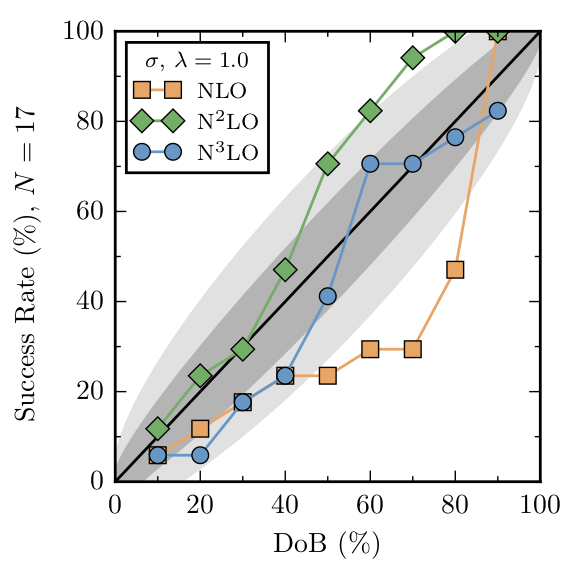

In [19]:
Image('../images/sgt_consistency.png', format='png', width=NARROW_IMG_WIDTH)

Each curve shows a slight discrepancy (only a few points) with Fig. 12, but that is expected since the priors are not identical between the figures. Now let's move on to pr($\Lambda_b | c$). The $\Lambda_b$ posteriors were computed with uninformative Set C prior, which corresponds exactly to $\nu_0 = 0$ for the inverse chi squared prior.
Thus, the figures generated below should correspond exactly with those in the paper.
Below, are some helper functions, including one to call the ``log_likelihood`` method, multiply by a prior, normalize the posterior, and extract summary statistics for the ``Lambda_b`` parameter.
Since the posteriors can be quite skewed, a highest probability density interval is calculated using the ``hpd_pdf`` function, rather than a simple symmetric credible interval.

In [20]:
def Lb_logprior(Lambda_b):
    """Melendez et al., Eq. (31)"""
    return np.where((300 <= Lambda_b) & (Lambda_b <= 1500), np.log(1. / Lambda_b), -np.inf)


def compute_posterior_intervals(model, data, ratios, ref, orders, max_idx, logprior, Lb):
    model.fit(data[:max_idx+1].T, ratio=ratios[0], ref=ref, orders=orders[:max_idx+1])
    log_like = np.array([model.log_likelihood(ratio=ratio) for ratio in ratios])
    log_like += logprior
    posterior = np.exp(log_like - np.max(log_like))
    posterior /= np.trapz(posterior, x=Lb)  # Normalize

    bounds = np.zeros((2,2))
    for i, p in enumerate([0.68, 0.95]):
        bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb)
        
    median = gm.median_pdf(pdf=posterior, x=Lb)
    return posterior, bounds, median


def draw_summary_statistics(bounds68, bounds95, median, height=0, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(bounds68, [height, height], c='darkgrey', lw=6, solid_capstyle='round')
    ax.plot(bounds95, [height, height], c='darkgrey', lw=2, solid_capstyle='round')
    ax.plot([median], [height], c='white', marker='o', zorder=10, markersize=3)

In [21]:
t_lab_Lb = np.array([96, 143, 200, 300])
degrees_Lb = np.array([60, 120])
X_Lb = gm.cartesian(t_lab_Lb, degrees_Lb)
Lb_colors = light_colors[2:]
Lambda_b_array = np.arange(1, 1501, 1)

# scale invariant: df = 0
Lb_model = gm.TruncationPointwise(df=0, excluded=nn_excluded)

ratios_sgt_Lb = [Q_approx(t_lab_Lb, Lb, interaction='np') for Lb in Lambda_b_array]
ratios_dsg_Lb = [Q_approx(X_Lb[:, 0], Lb, interaction='np') for Lb in Lambda_b_array]
logprior = Lb_logprior(Lambda_b_array)

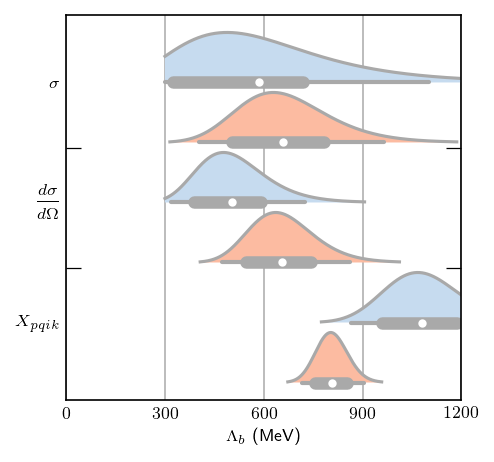

In [22]:
# Mask unused SGT data, and compute results
sgt_Lb = SGT[:, np.isin(t_lab, t_lab_Lb)]
sgt_Lb_n3lo_result = compute_posterior_intervals(
    Lb_model, sgt_Lb, ratios_sgt_Lb, ref=sgt_Lb[0], orders=orders, max_idx=3,
    logprior=logprior, Lb=Lambda_b_array)
sgt_Lb_n4lo_result = compute_posterior_intervals(
    Lb_model, sgt_Lb, ratios_sgt_Lb, ref=sgt_Lb[0], orders=orders, max_idx=4,
    logprior=logprior, Lb=Lambda_b_array)

# Mask unused DSG data, and compute results
dsg_Lb = np.reshape(DSG[:, np.isin(t_lab, t_lab_Lb)][..., np.isin(degrees, degrees_Lb)], (len(orders), -1))
dsg_Lb_n3lo_result = compute_posterior_intervals(
    Lb_model, dsg_Lb, ratios_dsg_Lb, ref=dsg_Lb[0], orders=orders, max_idx=3,
    logprior=logprior, Lb=Lambda_b_array)
dsg_Lb_n4lo_result = compute_posterior_intervals(
    Lb_model, dsg_Lb, ratios_dsg_Lb, ref=dsg_Lb[0], orders=orders, max_idx=4,
    logprior=logprior, Lb=Lambda_b_array)

# Concatenate all spin observable data into one long vector, and compute results
spins_Lb = np.concatenate([
    np.reshape(spin[:, np.isin(t_lab, t_lab_Lb)][..., np.isin(degrees, degrees_Lb)], (len(orders), -1))
    for spin in [AY, D, A, AXX, AYY]],
    axis=1)
ratios_spins_Lb = np.concatenate([ratios_dsg_Lb for i in [AY, D, A, AXX, AYY]], axis=1)
spins_Lb_n3lo_result = compute_posterior_intervals(
    Lb_model, spins_Lb, ratios_spins_Lb, ref=1, orders=orders, max_idx=3,
    logprior=logprior, Lb=Lambda_b_array)
spins_Lb_n4lo_result = compute_posterior_intervals(
    Lb_model, spins_Lb, ratios_spins_Lb, ref=1, orders=orders, max_idx=4,
    logprior=logprior, Lb=Lambda_b_array)

# Gather the above results
results = [
    sgt_Lb_n3lo_result, sgt_Lb_n4lo_result,
    dsg_Lb_n3lo_result, dsg_Lb_n4lo_result,
    spins_Lb_n3lo_result, spins_Lb_n4lo_result
]

# Plot each posterior and its summary statistics
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
for i, (posterior, bounds, median) in enumerate(results):
    posterior = posterior / (1.2*np.max(posterior))  # Scale so they're all the same height
    # Make the lines taper off
    Lb_vals = Lambda_b_array[posterior > 1e-2]
    posterior = posterior[posterior > 1e-2]
    # Plot and fill posterior, and add summary statistics
    ax.plot(Lb_vals, posterior-i, c='darkgrey')
    ax.fill_between(Lb_vals, -i, posterior-i, facecolor=Lb_colors[i % 2])
    draw_summary_statistics(*bounds, median, ax=ax, height=-i)

# Plot formatting
ax.set_yticks([-0, -2, -4])
ax.set_yticks([-1.1, -3.1], minor=True)
ax.set_yticklabels([r'$\sigma$', r'$\displaystyle\frac{d\sigma}{d\Omega}$', r'$X_{pqik}$'])
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(which='major', length=0)
ax.tick_params(which='minor', length=7, right=True)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.set_xlabel(r'$\Lambda_b$ (MeV)')
ax.grid(axis='x')
ax.set_axisbelow(True)

Compare the above figure with Fig. 22 of Melendez et al.:

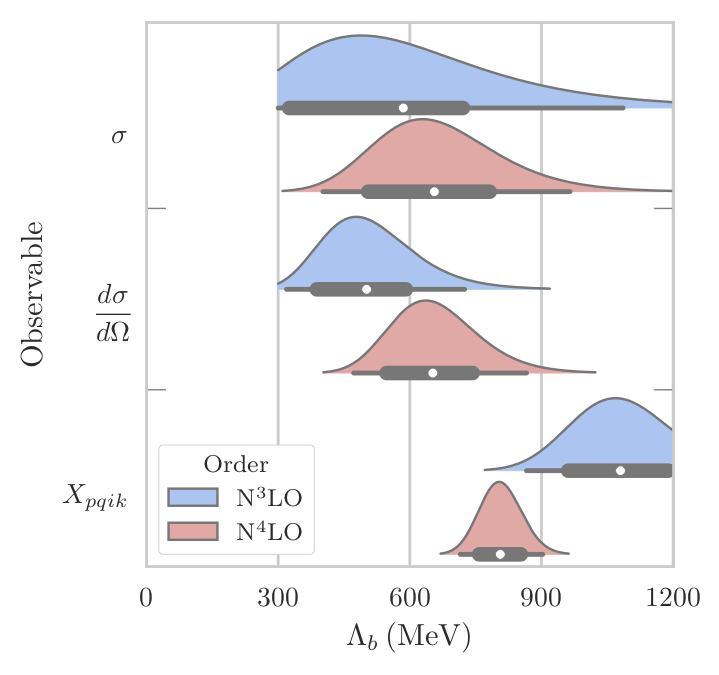

In [23]:
Image('../images/Lambdab_posteriors.png', format='png', width=NARROW_IMG_WIDTH)

## Conclusion

We have regenerated important figures from Furnstahl et al. and Melendez et al.
This code is significantly more condensed, efficient, and reusable than the original.
We believe that the ease with which results can be obtained with this package can greatly expand its domain of applicability.